In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import setGPU
from importlib import reload
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
sys.path.append(os.path.abspath(os.path.join('../../')))
import vande.analysis.analysis_roc as ar

setGPU: Setting GPU to: 0


In [2]:
import models.models as models
reload(models)
import models.losses as losses
reload(losses)
import utils.preprocessing as prepr
reload(prepr)

Using TensorFlow backend.


<module 'utils.preprocessing' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py'>

In [3]:
#Data Samples
DATA_PATH = '/eos/project/d/dshep/TOPCLASS/DijetAnomaly/VAE_data/events/'

TRAIN_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_sideband'
filename_bg = DATA_PATH + TRAIN_NAME + '_parts/' + TRAIN_NAME + '_000.h5'
batch_size = 128
train_set_size = int((5*10e3//batch_size)*batch_size)

In [4]:
nodes_n, feat_sz, particles_bg  = prepr.prepare_data_constituents(filename_bg,train_set_size,0,train_set_size+1)


/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/preprocessing.py:8: RuntimeWarning: divide by zero encountered in log
  return np.where(x==0,-10,np.log(x))


Number of jets = 98135
Number of constituents (nodes) = 50
Number of features = 3


In [5]:

# BG validation
VALID_NAME = 'qcd_sqrtshatTeV_13TeV_PU40_NEW_EXT_sideband'
filename_bg_valid = DATA_PATH + VALID_NAME + '_parts/' + VALID_NAME + '_000.h5'
valid_set_size = int((10e3//batch_size)*batch_size)
_,_, particles_bg_valid = prepr.prepare_data_constituents(filename_bg_valid,valid_set_size,0,valid_set_size+1)



Number of jets = 19650
Number of constituents (nodes) = 50
Number of features = 3


In [6]:
#BG test
_,_, particles_bg_test = prepr.prepare_data_constituents(filename_bg_valid,5000,valid_set_size+1,valid_set_size+5000)


Number of jets = 9840
Number of constituents (nodes) = 50
Number of features = 3


In [7]:
#signal
SIG_MASS = '3.5'
SIG_NAME = 'RSGraviton_WW_NARROW_13TeV_PU40_'+SIG_MASS+'TeV_NEW'
filename_sig = DATA_PATH + SIG_NAME + '_parts/' + SIG_NAME + '_concat_001.h5'
_,_, particles_sig = prepr.prepare_data_constituents(filename_sig,5000,0,5000)

Number of jets = 9966
Number of constituents (nodes) = 50
Number of features = 3


In [8]:
output_file = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/input/QCD_training_data.h5'
with h5py.File(output_file, 'w')as outFile:
    outFile.create_dataset('particle_bg', data=particles_bg, compression='gzip')
    outFile.create_dataset('particle_bg_valid', data=particles_bg_valid, compression='gzip')
    outFile.create_dataset('particle_sig', data=particles_bg_valid, compression='gzip')

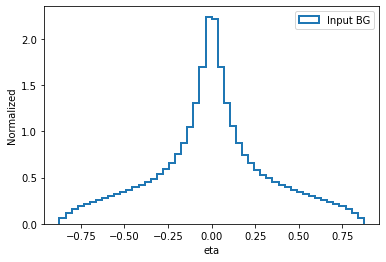

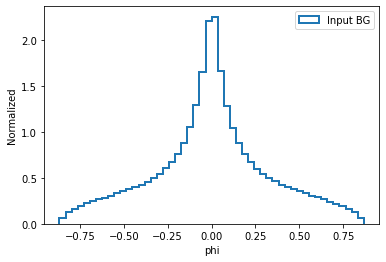

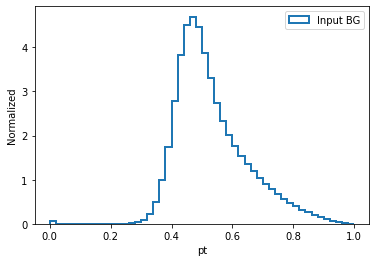

In [9]:
feats = 'eta,phi,pt'.split(',')
for i in range(0,3):
    xmin = np.quantile(particles_bg[:,:,i].flatten(),0.05)
    xmax = np.quantile(particles_bg[:,:,i].flatten(),0.98)
    plt.figure()
    plt.hist(particles_bg[:,:,i].flatten(), bins=50, label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(loc='upper right')
    #plt.semilogy()
    plt.show()

# Particle Net AE

In [9]:
import models.PNmodel as pn
reload(pn)

<module 'models.PNmodel' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/PNmodel.py'>

In [194]:
input_shapes = {}
input_shapes['points'] =  [nodes_n,feat_sz-1] #using only coordinates eta phi
input_shapes['features'] = [nodes_n,feat_sz]
input_shapes['mask'] = None
model = pn.get_particle_net_lite_ae(input_shapes)
model.summary()

64
Model: "ParticleNetAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_50 (Tenso [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_115 (Ten [(None, 50, 1, 3)]   0           features[0][0]                   
___________________________________________________________________________________

In [197]:
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

optim = Adam(learning_rate=0.001)

# Compile the Model
model.compile(optimizer=optim, loss=losses.threeD_loss)
#model.compile(optimizer=optim, loss='mse')

In [198]:

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

history = model.fit((particles_bg[:500000,:,0:2], particles_bg[:500000,:,:]) ,  particles_bg[:500000,:,:],
                    validation_data = ((particles_bg_valid[:100000,:,0:2], particles_bg_valid[:100000,:,:]) , particles_bg_valid[:100000,:,:]),
                    epochs=10, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls]) 

Epoch 1/10
390/390 [==============================] - 9s 23ms/step - loss: 0.0371 - val_loss: 0.0430
Epoch 2/10
390/390 [==============================] - 8s 21ms/step - loss: 0.0318 - val_loss: 0.0388
Epoch 3/10
390/390 [==============================] - 8s 21ms/step - loss: 0.0304 - val_loss: 0.0348
Epoch 4/10
390/390 [==============================] - 8s 21ms/step - loss: 0.0297 - val_loss: 0.0336
Epoch 5/10
390/390 [==============================] - 8s 21ms/step - loss: 0.0293 - val_loss: 0.0322
Epoch 6/10
390/390 [==============================] - 9s 22ms/step - loss: 0.0289 - val_loss: 0.0329
Epoch 7/10
390/390 [==============================] - 8s 22ms/step - loss: 0.0287 - val_loss: 0.0330
Epoch 8/10
390/390 [==============================] - 8s 22ms/step - loss: 0.0284 - val_loss: 0.0312
Epoch 9/10
390/390 [==============================] - 8s 22ms/step - loss: 0.0282 - val_loss: 0.0307
Epoch 10/10
390/390 [==============================] - 8s 21ms/step - loss: 0.0281 - val_lo

In [10]:
models_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/output_models/'
model_path = models_dir + "output_model_saved_PN_AE_2021_07_30_T_09_26"
loaded_model = tf.keras.models.load_model(
    model_path,
    custom_objects={"PN_AE": pn.get_particle_net_lite_ae, "threeD_loss":losses.threeD_loss}
)

weights_path = models_dir +'PN_AE_weights_2021_07_29_T_18_19.25-0.023.hdf5'
loaded_model.load_weights(
    weights_path, by_name=True, skip_mismatch=False)

NameError: name 'filepath' is not defined

In [382]:
Y_bg_predict[1].shape

(5000, 50, 3)

In [385]:
#model = loaded_model

_,Y_bg_predict = model.predict([particles_bg_test[:,:,0:2],particles_bg_test])
_,Y_sig_predict = model.predict([particles_sig[:,:,0:2],particles_sig])

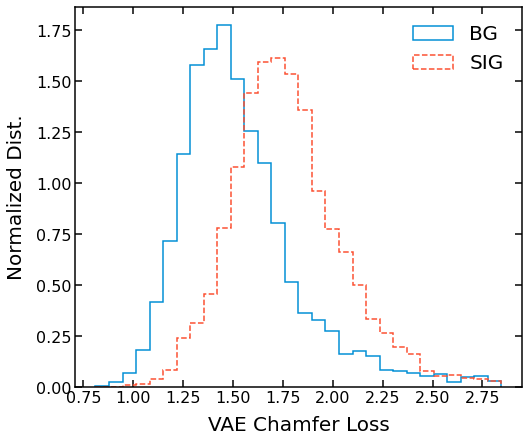

In [387]:
loss_bg = losses.threeD_loss_manual(particles_bg_test,Y_bg_predict)
loss_sig = losses.threeD_loss_manual(particles_sig,Y_sig_predict)
#loss_bg = losses.mse_loss_manual(particles_bg_test,Y_bg_predict)
#loss_sig = losses.mse_loss_manual(particles_sig,Y_sig_predict)


plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')

max_score = np.quantile(loss_sig,0.99)#,np.max(loss_bg_dist))
min_score = np.min(loss_bg)#,np.max(loss_bg_dist))
bins = 30
# plot BG
plt.figure()
plt.hist(loss_bg, bins=bins, label='BG', density=True, range=(min_score, max_score), 
         histtype='step', fill=False, linewidth=1.5)
plt.hist(loss_sig, bins=bins, label='SIG', density=True, range=(min_score, max_score), 
         histtype='step', linestyle='--',fill=False, linewidth=1.5)
#plt.semilogy()
plt.xlabel("VAE Chamfer Loss")
plt.ylabel("Normalized Dist.")
plt.legend(loc='upper right')
savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_ae.pdf'
plt.savefig(savename)
plt.show()

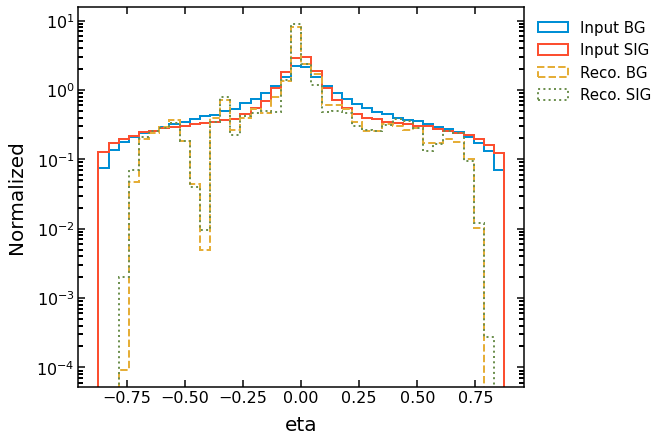

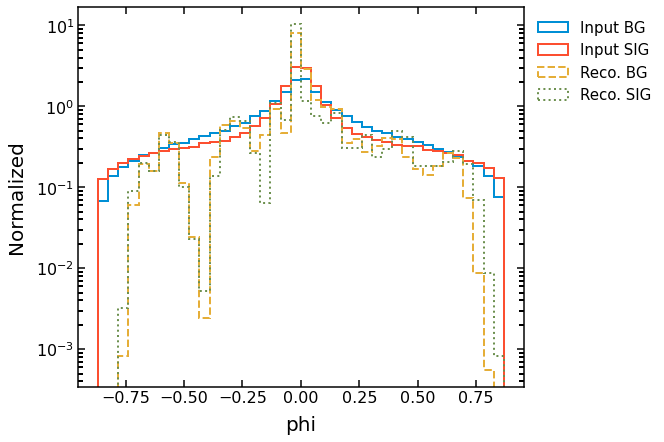

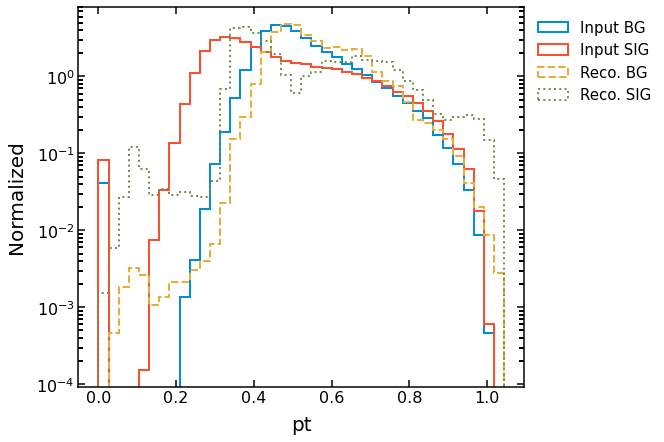

In [388]:
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
for i in range(0,len(feats)):
    #xmin = np.quantile(particles_bg[:,:,i].flatten(),0.)
    #xmax = np.quantile(particles_bg[:,:,i].flatten(),1)
    xmin = np.min([np.min(particles_bg[:,:,i].flatten()),np.min(Y_bg_predict[:,:,i].flatten())])
    xmax = np.max([np.max(particles_bg[:,:,i].flatten()),np.max(Y_bg_predict[:,:,i].flatten())])
    n_bins = 40
    plot_range = (xmin,xmax)
    plt.figure()
    _,bins,_ = plt.hist(particles_bg_test[:,:,i].flatten(), bins=n_bins, range = plot_range,label='Input BG', density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(particles_sig[:,:,i].flatten(), bins=bins, label='Input SIG',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_bg_predict[:,:,i].flatten(), bins=bins, label='Reco. BG', linestyle='--',density=True, histtype='step', fill=False, linewidth=2)
    _,_,_ = plt.hist(Y_sig_predict[:,:,i].flatten(), bins=bins, label='Reco. SIG', linestyle=':',density=True, histtype='step', fill=False, linewidth=2)
    plt.xlabel(feats[i])
    plt.ylabel("Normalized")
    plt.legend(bbox_to_anchor=(1., 1.),fontsize=15)
    plt.semilogy()
    savename = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/reco_edgeconv_pn_ae_{}_test.pdf'.format(feats[i])
    plt.savefig(savename)
    plt.show()

/eos/home-n/nchernya/MLHEP/AnomalyDetection/vande/analysis/analysis_roc.py:33: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")")


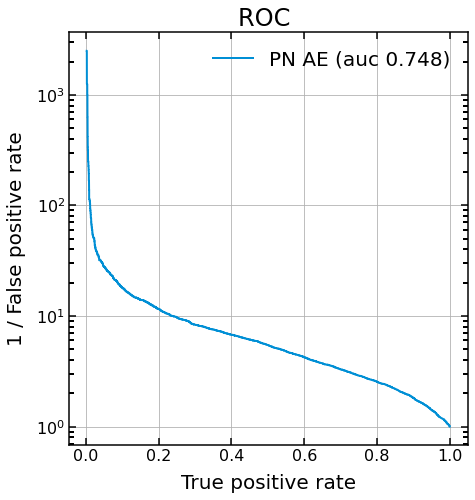

[0.7480986399999999]

In [389]:
neg_class_losses = [loss_bg.tolist()]
pos_class_losses = [loss_sig.tolist()]

plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
ar.plot_roc( neg_class_losses, pos_class_losses, legend=['PN AE'], title='ROC ',
            plot_name='ROC_pnae_test', fig_dir='/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/figs/',log_x=False )


In [56]:
#dataset= tf.data.Dataset.from_tensor_slices((particles_bg[:,:,0:2], particles_bg))


(array([[ 0.,  3.,  0.,  1.,  1.,  4.,  0.,  0.,  4.,  0.,  3.,  2.,  1.,
          0.,  0.,  3.,  6.,  2.,  4.,  1.,  2.,  7.,  6.,  1.,  4.,  4.,
          4.,  1.,  3.,  3.,  4.,  0.,  3.,  1.,  2.,  2.,  0.,  2.,  1.,
          3.,  3.,  3.,  1.,  2.,  2.,  0.,  0.,  0.,  0.,  1.],
        [ 1.,  1.,  1.,  0.,  2.,  1.,  0.,  2.,  1.,  0.,  2.,  0.,  2.,
          2.,  3.,  4.,  2.,  4.,  2.,  5.,  4.,  4.,  4.,  6.,  1.,  3.,
          4.,  5.,  5.,  3.,  0.,  1.,  3.,  3.,  1.,  1.,  0.,  3.,  1.,
          3.,  2.,  0.,  3.,  2.,  1.,  0.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7., 12., 13., 15.,
         15., 10.,  8.,  6.,  4.,  1.,  3.,  1.,  0.,  1.,  4.]]),
 array([-0.7176487 , -0.6873638 , -0.657079  , -0.6267941 , -0.5965093 ,
        -0.5662244 , -0.5359396 , -0.5056547 , -0.47536984, -0.4

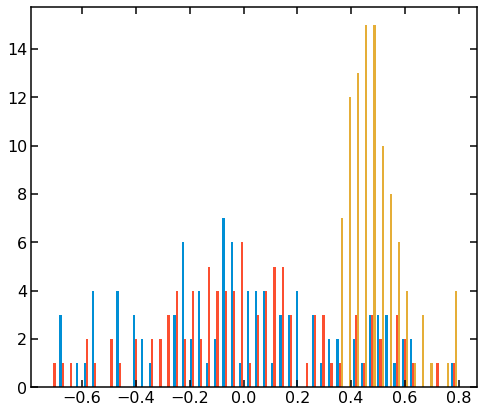

In [174]:
#plt.hist(particles_bg[2],bins=50) # trasnformed, I think it does this double peak, 
#because features and coordinates are summed (from the shortcut)
#could batch norm help with this?

#also try to do std transformation of pt instead

In [ ]:
#looks like batch normalization helped with the double peak

In [ ]:
#try to remove batch norm before latent space

In [267]:
reload(models)
import models.PNmodel as pn
reload(pn)


<module 'models.PNmodel' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/PNmodel.py'>

In [344]:
input_shapes = {}
input_shapes['points'] =  [nodes_n,feat_sz-1] #using only coordinates eta phi
input_shapes['features'] = [nodes_n,feat_sz]
input_shapes['mask'] = None
ae_info = {}
ae_info['latent_dim'] = 10
ae_info['ae_type'] = 'ae'
model = pn.get_particle_net_lite_ae(input_shapes,ae_info)


In [345]:

#optim = Adam(learning_rate=0.001)

# Compile the Model
#model.compile(optimizer=optim, loss=losses.threeD_loss)

In [346]:
model.summary()

Model: "ParticleNetae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_108 (Tens [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_263 (Ten [(None, 50, 1, 3)]   0           features[0][0]                   
______________________________________________________________________________________

In [271]:

# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

history = model.fit((particles_bg[:500000,:,0:2], particles_bg[:500000,:,:]) ,  particles_bg[:500000,:,:],
                    validation_data = ((particles_bg_valid[:100000,:,0:2], particles_bg_valid[:100000,:,:]) , particles_bg_valid[:100000,:,:]),
                    epochs=10, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls]) 

Epoch 1/10


_SymbolicException: Inputs to eager execution function cannot be Keras symbolic tensors, but found [<tf.Tensor 'z_mean/leaky_re_lu_887/LeakyRelu:0' shape=(None, 10) dtype=float32>, <tf.Tensor 'z_log_var/leaky_re_lu_887/LeakyRelu:0' shape=(None, 10) dtype=float32>]

In [375]:

input_shapes = {}
input_shapes['points'] =  [nodes_n,feat_sz-1] #using only coordinates eta phi
input_shapes['features'] = [nodes_n,feat_sz]
input_shapes['mask'] = None
ae_info = {}
ae_info['latent_dim'] = 10
ae_info['ae_type'] = 'ae'

class _DotDict:
    pass


if 1>0:
    setting = _DotDict()
    # conv_params: list of tuple in the format (K, (C1, C2, C3))
    setting.conv_params = [
        (7, (32, 32, 32)),
        (7, (64, 64, 64)),
        ]
    # conv_pooling: 'average' or 'max'
    setting.conv_pooling = 'average'
    # fc_params: list of tuples in the format (C, drop_rate)
    setting.fc_params = None 
    setting.num_points = input_shapes['points'][0] #num of original consituents
    setting.num_features = input_shapes['features'][1] #num of original features
    setting.latent_dim = ae_info['latent_dim'] 
    setting.ae_type = ae_info['ae_type'] #'ae' #ae or vae 



In [376]:
import models.models as models
reload(models)
import models.layers as layers
reload(layers)
import models.PNmodel as pn
reload(pn)
import models.custom_functions as funcs
reload(funcs)
import models.ParticleNetAE as pnae
reload(pnae)

<module 'models.ParticleNetAE' from '/eos/home-n/nchernya/MLHEP/AnomalyDetection/ADgvae/models/ParticleNetAE.py'>

In [377]:
model = pnae.PNVAE(input_shapes=input_shapes,setting=setting,mask=None,name='PN_')


Model: "ParticleNetBase"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
points (InputLayer)             [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
features (InputLayer)           [(None, 50, 3)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_Transpose_120 (Tens [(None, 2, 50)]      0           points[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_293 (Ten [(None, 50, 1, 3)]   0           features[0][0]                   
____________________________________________________________________________________

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 10)]              0         
_________________________________________________________________
dense_41 (Dense)             (None, 1250)              13750     
_________________________________________________________________
PN__bn_1 (BatchNormalization (None, 1250)              5000      
_________________________________________________________________
reshape_16 (Reshape)         (None, 50, 25)            0         
_________________________________________________________________
tf_op_layer_ExpandDims_300 ( [(None, 50, 1, 25)]       0         
_________________________________________________________________
PN__conv_0 (Conv2D)          (None, 50, 1, 9)          234       
_________________________________________________________________
tf_op_layer_Squeeze_176 (Ten [(None, 50, 9)]           0   

In [378]:
optim = Adam(learning_rate=0.001)

model.compile(optimizer=optim)


# early stopping callback
es = EarlyStopping(monitor='val_loss', patience=10)

# Learning rate scheduler 
ls = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

history = model.fit((particles_bg[:500000,:,0:2], particles_bg[:500000,:,:]) ,  particles_bg[:500000,:,:],
                    validation_data = ((particles_bg_valid[:100000,:,0:2], particles_bg_valid[:100000,:,:]) , particles_bg_valid[:100000,:,:]),
                    epochs=3, 
                    batch_size=128, 
                    verbose=1,
                    callbacks=[es,ls]) 

Epoch 1/3
390/390 [==============================] - 9s 22ms/step - val_loss: 0.0333
Epoch 2/3
390/390 [==============================] - 8s 21ms/step - val_loss: 0.0303
Epoch 3/3
390/390 [==============================] - 8s 21ms/step - val_loss: 0.0301
